In [8]:
import sys
default_stdout = sys.stdout
default_stderr = sys.stderr

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import anuga
from anuga import rectangular_cross
from anuga import Domain
from anuga import Dirichlet_boundary, Reflective_boundary

reload(sys)
sys.stdout = default_stdout
sys.stderr = default_stderr

#===============================================================================
# Setup Functions
#===============================================================================

filename_root = 'data/raster'

# Convert an elevation raster into a point file
anuga.asc2dem(filename_root + '.asc', use_cache = False, verbose = True)
anuga.dem2pts(filename_root + '.dem', use_cache = False, verbose = True)


"""
Include the process-specific quantities when creating the domain
"""        

# import bounding polygon text file, set boundary tags
bounding_polygon = anuga.read_polygon('data/outline.csv')
boundary_tags = {'bottom':[0],
                  'side1':[1],
                  'side2':[2],
                    'top':[3],
                  'side3':[4],
                  'side4':[5]}

"""
Create the domain
"""
domain = anuga.create_domain_from_regions(bounding_polygon = bounding_polygon,
                         boundary_tags = boundary_tags,
                         maximum_triangle_area = 200,
                         mesh_filename = filename_root + '.msh')


#------------------------------------------------------------------------------
# Setup parameters of computational domain
#------------------------------------------------------------------------------

# Print some stats about mesh and domain
print 'Number of triangles = ', len(domain)
print 'The extent is ', domain.get_extent()
print domain.statistics()


domain.set_quantity('elevation', 
                    filename = filename_root + '.pts',
                    use_cache = False,
                    verbose = True,
                    alpha = 0.1)
                    

domain.set_flow_algorithm('DE0')
domain.set_name('topo') # Output name
domain.set_quantity('stage', expression='elevation')   # Dry initial condition


"""
Store process-specific quantities with same functions
""" 
domain.set_quantities_to_be_stored({'elevation': 1,
                                    'stage': 2,
                                    'xmomentum': 2,
                                    'ymomentum': 2})
                                    
#------------------------------------------------------------------------------
# Setup boundary conditions
#------------------------------------------------------------------------------
min_elev = domain.quantities['elevation'].vertex_values.min()

Bd = Dirichlet_boundary([1528, 0., 0.])
Bi = Dirichlet_boundary([min_elev - 1, 0., 0.])
Br = Reflective_boundary(domain)

domain.set_boundary({'bottom':Bi,
                      'side1':Br,
                      'side2':Br,
                        'top':Bd,
                      'side3':Br,
                      'side4':Br,
                   'exterior':Br})

Reading METADATA from data/raster.prj
Reading DEM from data/raster.asc
Got 292 lines
Store to NetCDF file data/raster.dem
Reading DEM from data/raster.dem
Store to NetCDF file data/raster.pts
There are 80652 values in the elevation
There are 80652 values in the clipped elevation
There are 37882 NODATA_values in the clipped elevation
Generating mesh to file 'data/raster.msh'
Domain: Initialising
Pmesh_to_Domain: Initialising
Pmesh_to_Domain: Done
General_mesh: Building basic mesh structure
General_mesh: Computing areas, normals, edgelengths, centroids and radii
General Mesh: Building inverted triangle structure
Mesh: Initialising
Mesh: Building neigbour structure
Mesh: Building surrogate neigbour structure
Mesh: Building boundary dictionary
Mesh: Building tagged elements dictionary
Mesh: Done
Domain: Expose mesh attributes
Domain: Expose quantity names and types
Domain: Build Quantities
Domain: Set up communication buffers 
Domain: Set up triangle/node full flags 
Domain: Set defaults
D

In [9]:
#------------------------------------------------------------------------------
# Evolve system through time
#------------------------------------------------------------------------------
for t in domain.evolve(yieldstep = 10, finaltime = 1500.0):
    domain.print_timestepping_statistics()

Time = 0.0000, steps=0 (6s)
Time = 10.0000, delta t in [0.92808971, 1.25975383], steps=9 (0s)
Time = 20.0000, delta t in [0.43834795, 0.69907786], steps=21 (0s)
Time = 30.0000, delta t in [0.45942024, 0.47948627], steps=22 (0s)
Time = 40.0000, delta t in [0.46503092, 0.47762426], steps=22 (0s)
Time = 50.0000, delta t in [0.46640128, 0.48171132], steps=22 (0s)
Time = 60.0000, delta t in [0.48173534, 0.48460534], steps=21 (0s)
Time = 70.0000, delta t in [0.47537642, 0.48755556], steps=21 (0s)
Time = 80.0000, delta t in [0.48765110, 0.49043793], steps=21 (0s)
Time = 90.0000, delta t in [0.49050855, 0.49366883], steps=21 (0s)
Time = 100.0000, delta t in [0.49372188, 0.49701719], steps=21 (0s)
Time = 110.0000, delta t in [0.49704662, 0.49992258], steps=21 (0s)
Time = 120.0000, delta t in [0.49993139, 0.50297663], steps=20 (0s)
Time = 130.0000, delta t in [0.50315497, 0.50763306], steps=20 (0s)
Time = 140.0000, delta t in [0.50789848, 0.51625839], steps=20 (0s)
Time = 150.0000, delta t in [0

In [3]:
#------------------------------------------------------------------------------
# Quantities
#------------------------------------------------------------------------------
print domain.quantities.keys()

['xvelocity', 'elevation', 'friction', 'height', 'xmomentum', 'y', 'x', 'yvelocity', 'ymomentum', 'stage']


In [10]:
#------------------------------------------------------------------------------
# Import SWW file to np arrays
#------------------------------------------------------------------------------
from netCDF4 import Dataset

swwFile = 'topo.sww'
fid = Dataset(swwFile, mode='r')

x = fid.variables['x'][:]
y = fid.variables['y'][:]
elev = fid.variables['elevation'][:]
stage = fid.variables['stage'][:]

depth = stage - elev

xmom = fid.variables['xmomentum'][:]
xvel = (xmom * depth) / (depth**2 + 0.0001)

ymom = fid.variables['ymomentum'][:]
yvel = (ymom * depth) / (depth**2 + 0.0001)

fid.close()

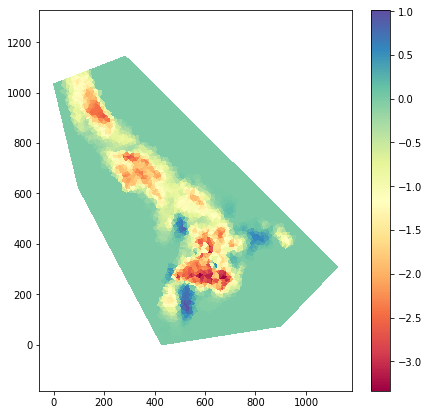

In [6]:
#------------------------------------------------------------------------------
# Create triangulation
#------------------------------------------------------------------------------
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri

triang = mtri.Triangulation(x, y)

plt.figure(figsize=(7,7))
plt.tripcolor(triang, yvel[-1],  shading='flat', edgecolors='none', cmap='Spectral')
plt.colorbar()
plt.axis('equal');

In [ ]:
#------------------------------------------------------------------------------
# Animate
#------------------------------------------------------------------------------

from matplotlib import animation
from JSAnimation import IPython_display

pad = 100

fig = plt.figure()
ax = plt.axes(xlim=(0, x.max()+pad), ylim=(0, y.max()+pad))
trip = ax.tripcolor(triang, depth[0], shading='gouraud', edgecolors='none', cmap='YlGnBu', vmin = 0, vmax = 1)
ax.axis('equal');
fig.colorbar(trip)

def animate(i):
    
    ax.clear()
    trip = ax.tripcolor(triang, depth[i], shading='gouraud', edgecolors='none', cmap='YlGnBu', vmin = 0, vmax = 1)

    return trip,

animation.FuncAnimation(fig, animate, frames=range(0,len(depth), 20), interval=150)